# Homework 1: Futures Spread Data Characterization
---
#### Philip Lee
#### ID: 12129240

# 1 Introduction

Here we will practice obtaining data for spreads in futures markets, and characterizing their dynamics.

# 2 Data

Obtain second month quarterly 1 futures prices from the Quandl OWF database for two pair W, X; Y, Z (where W, X and Y and Z depend on your student ID number) for 3 Dec 2019 though 31 Aug 2021. Our defi- nition of second month is the contact where the number of days to futures expiration is the smallest available value greater than 30.

Form the spreads s(1), s(2) between these numbers as the difference s(1) = X − W and s(2) = Z − Y .

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import requests
import quandl
import functools
import re

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import API_KEY

quandl.ApiConfig.api_key = API_KEY

In [66]:
DB         = "OWF/"
ASSETS     = ["CBT_FV_FV", "CBT_TU_TU", "ICE_B_B", "ICE_G_G"]
QUARTERS   = ['H', 'M', 'U', 'Z']
YEARS      = ["2020", "2021"]
SUFFIX     = "_IVM"
START_DATE = "2019-12-03"
END_DATE   = "2021-08-31"

pull       = [DB+a+'_'+q+y+SUFFIX for y in YEARS
                              for q in QUARTERS
                              for a in ASSETS]
display(pull[:4])

['OWF/CBT_FV_FV_H2020_IVM',
 'OWF/CBT_TU_TU_H2020_IVM',
 'OWF/ICE_B_B_H2020_IVM',
 'OWF/ICE_G_G_H2020_IVM',
 'OWF/CBT_FV_FV_M2020_IVM',
 'OWF/CBT_TU_TU_M2020_IVM',
 'OWF/ICE_B_B_M2020_IVM',
 'OWF/ICE_G_G_M2020_IVM']

In [3]:
if "pull_quandl" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    @functools.lru_cache(maxsize=16)
    def pull_quandl(pull, start_date, end_date):
        ret = quandl.get(list(pull), start_date=start_date, end_date=end_date)
        return ret

owf_raw = pull_quandl(tuple(pull), START_DATE, END_DATE)
display(owf_raw.head())

Defining quandl pull


,OWF/CBT_FV_FV_H2020_IVM - Future,OWF/CBT_FV_FV_H2020_IVM - AtM,OWF/CBT_FV_FV_H2020_IVM - RR25,OWF/CBT_FV_FV_H2020_IVM - RR10,OWF/CBT_FV_FV_H2020_IVM - Fly25,OWF/CBT_FV_FV_H2020_IVM - Fly10,OWF/CBT_FV_FV_H2020_IVM - Beta1,OWF/CBT_FV_FV_H2020_IVM - Beta2,OWF/CBT_FV_FV_H2020_IVM - Beta3,OWF/CBT_FV_FV_H2020_IVM - Beta4,...,OWF/ICE_G_G_Z2021_IVM - Beta1,OWF/ICE_G_G_Z2021_IVM - Beta2,OWF/ICE_G_G_Z2021_IVM - Beta3,OWF/ICE_G_G_Z2021_IVM - Beta4,OWF/ICE_G_G_Z2021_IVM - Beta5,OWF/ICE_G_G_Z2021_IVM - Beta6,OWF/ICE_G_G_Z2021_IVM - MinMoney,OWF/ICE_G_G_Z2021_IVM - MaxMoney,OWF/ICE_G_G_Z2021_IVM - DtE,OWF/ICE_G_G_Z2021_IVM - DtT
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,119.3672,0.0274,0.0005,0.0017,0.0004,0.0019,0.0224,4.5335,76.6694,5394.3322,...,-0.0209,-0.2711,1.4202,9.4362,-59.9190,83.4223,-0.1374,0.2537,730.8500,738.0000
2019-12-04,118.9922,0.0265,0.0005,0.0012,0.0006,0.0025,0.0292,7.8833,-0.4661,1046.9718,...,-0.0167,-0.2247,0.5764,8.9464,-18.1752,-38.2658,-0.1526,0.2385,729.8500,737.0000
2019-12-05,118.9219,0.0270,0.0006,0.0013,0.0005,0.0023,0.0349,6.4356,-15.9653,4287.8200,...,-0.0179,-0.2153,0.6176,8.2396,-17.5342,-34.6087,-0.1549,0.2363,728.8500,736.0000
2019-12-06,118.6641,0.0266,0.0009,0.0018,0.0009,0.0034,0.0500,12.5606,-26.6452,-7024.1396,...,-0.0174,-0.2521,0.4546,10.0946,-12.2060,-70.5269,-0.1572,0.2340,727.8500,735.0000
2019-12-09,118.6797,0.0266,0.0014,0.0027,0.0010,0.0038,0.0826,15.3082,-73.0926,-12297.5427,...,-0.0175,-0.2418,0.5082,9.5430,-15.0781,-54.4704,-0.1558,0.2354,724.8500,732.0000


In [4]:
def clean_columns(s: str, pre=len(DB)):
    """Takes in Quandl formatted column names...
    returns a list to construct a pd.MultiIndex
    "OWF/CBT_FV_FV_H2020_IVM - Future" -> ['CBT_FV_FV', 'H2020', 'Future']
    """
    ret = re.split(r"([A-Z]\d{4})|( - )", s[pre:])
    return [ret[0][:-1], ret[1], ret[-1]]

test_col = owf_raw.columns[0]
print(f"IN:\n{test_col}\nOUT:\n{clean_columns(test_col)}")

IN:
OWF/CBT_FV_FV_H2020_IVM - Future
OUT:
['CBT_FV_FV', 'H2020', 'Future']


In [13]:
owf_clean = owf_raw.copy(deep=True)
owf_clean.columns = pd.MultiIndex.from_arrays(
    np.array([clean_columns(c) for c in owf_clean.columns]).T,
    names=("ASSET", "EXP", "MEASURE"))

display(owf_clean.head())

ASSET      CBT_FV_FV                                                    \
EXP            H2020                                                     
MEASURE       Future    AtM   RR25   RR10  Fly25  Fly10  Beta1   Beta2   
Date                                                                     
2019-12-03  119.3672 0.0274 0.0005 0.0017 0.0004 0.0019 0.0224  4.5335   
2019-12-04  118.9922 0.0265 0.0005 0.0012 0.0006 0.0025 0.0292  7.8833   
2019-12-05  118.9219 0.0270 0.0006 0.0013 0.0005 0.0023 0.0349  6.4356   
2019-12-06  118.6641 0.0266 0.0009 0.0018 0.0009 0.0034 0.0500 12.5606   
2019-12-09  118.6797 0.0266 0.0014 0.0027 0.0010 0.0038 0.0826 15.3082   

ASSET                            ... ICE_G_G                                  \
EXP                              ...   Z2021                                   
MEASURE       Beta3       Beta4  ...   Beta1   Beta2  Beta3   Beta4    Beta5   
Date                             ...                                           
2019-12-03  76.6694   5394.3322  ... -0.0209 -0.2711 1.4202  9.4362 -59.9190   
2019-12-04  -0.4661   1046.9718  ... -0.0167 -0.2247 0.5764  8.9464 -18.1752   
2019-12-05 -15.9653   4287.8200  ... -0.0179 -0.2153 0.6176  8.2396 -17.5342   
2019-12-06 -26.6452  -7024.1396  ... -0.0174 -0.2521 0.4546 10.0946 -12.2060   
2019-12-09 -73.0926 -12297.5427  ... -0.0175 -0.2418 0.5082  9.5430 -15.0781   

ASSET                                                    
EXP                                                      
MEASURE       Beta6 MinMoney MaxMoney      DtE      DtT  
Date                                                     
2019-12-03  83.4223  -0.1374   0.2537 730.8500 738.0000  
2019-12-04 -38.2658  -0.1526   0.2385 729.8500 737.0000  
2019-12-05 -34.6087  -0.1549   0.2363 728.8500 736.0000  
2019-12-06 -70.5269  -0.1572   0.2340 727.8500 735.0000  
2019-12-09 -54.4704  -0.1558   0.2354 724.8500 732.0000  

[5 rows x 512 columns]

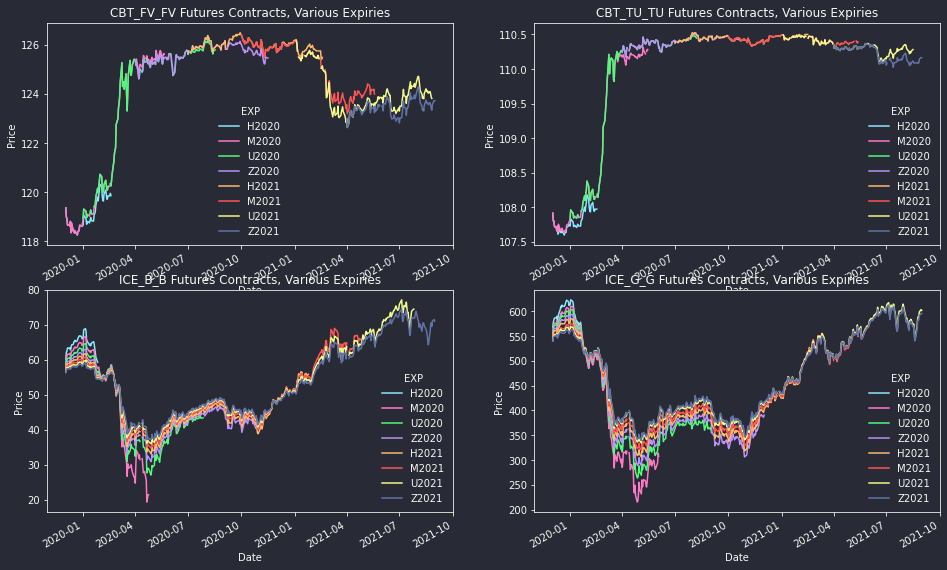

In [124]:
fig, axs = plt.subplots(2,2)

for i, a in enumerate(ASSETS):
    to_plot = owf_clean[a]
    to_plot.swaplevel(0,1,axis=1)["Future"].plot(ax=axs[i//2,i%2])
    axs[i//2,i%2].set_title(f"{a} Futures Contracts, Various Expiries")
    axs[i//2,i%2].set_ylabel("Price ($)")
    
plt.show()

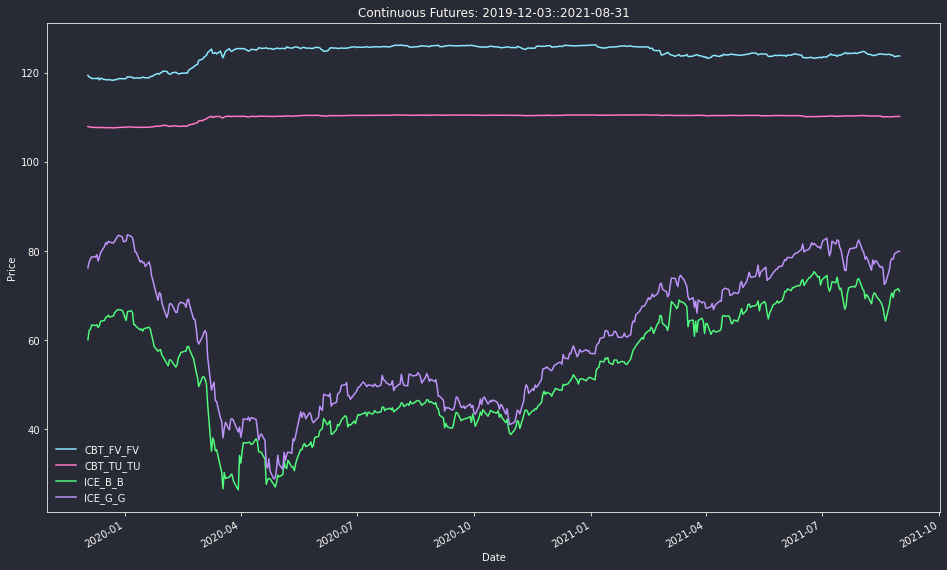

In [142]:
def qtrly_to_cont(df, thresh=30):
    expiries = df.swaplevel(0,1,axis=1)["DtT"].interpolate(method="linear", limit_area="inside")
    prices   = df.swaplevel(0,1,axis=1)["Future"].fillna(method="ffill")
    mins     = expiries[expiries>thresh].idxmin(axis=1)
    ret      = (pd.get_dummies(mins)[expiries.columns] * prices).sum(axis=1)
    #           ^ a DF with 1 if closest to exp        ^ elem mul  ^ quarterly prices
    return ret

cont = []
for a in ASSETS:
    cont.append(qtrly_to_cont(owf_clean[a]))

cont_fut = pd.concat(cont, axis=1, keys=ASSETS)
cont_fut["ICE_G_G"] /= 7.45
cont_fut.plot()
plt.title(f"Continuous Futures: {START_DATE}::{END_DATE}")
plt.ylabel("Price ($)")
plt.show()

In [143]:
owf_clean.loc[["2020-04-10", "2020-12-25", "2021-04-02"],:].swaplevel(1,2,1)["ICE_B_B"]["DtT"]

EXP,H2020,M2020,U2020,Z2020,H2021,M2021,U2021,Z2021
Date,,,,,,,,
2020-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
s1 = cont_fut[ASSETS[1]] - cont_fut[ASSETS[0]]
s2 = cont_fut[ASSETS[3]] - cont_fut[ASSETS[2]]

display(pd.DataFrame(
    {"Actual": [s1["2021-02-18"], s1["2021-02-19"], s2["2021-02-08"], s2["2021-02-09"]],
     "Expected": [-15.000000, -14.496875, 6.606510, 6.719866]}))

,Actual,Expected
0,-15.0000,-15.0000
1,-14.4969,-14.4969
2,6.6065,6.6065
3,6.7199,6.7199


# 3 Analysis
Characterize the relative dynamics of s(i) in reasonable ways, using charts t
and statistics.

For example, compute the median and standard deviation of the difference
d(N) between s(i) and an N-day rolling average of s for some values of N.

Examine more quantiles than just the median. Look at tails. Do the spreads correlate? How about their difference (d) values? Do spreads exhibit patterns over time?

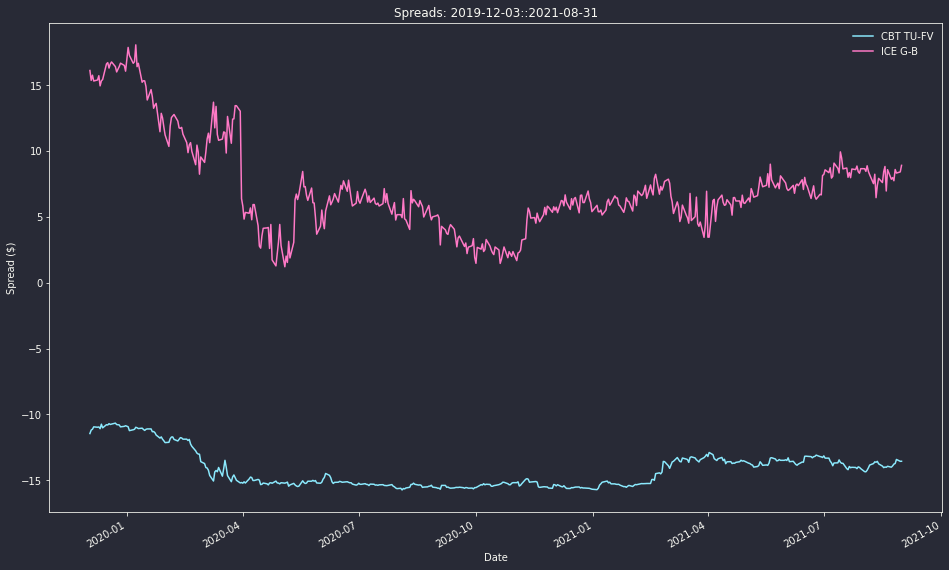

In [147]:
spreads = pd.concat([s1, s2], axis=1, keys=["CBT TU-FV", "ICE G-B"])
spreads.plot()
plt.title(f"Spreads: {START_DATE}::{END_DATE}")
plt.ylabel("Spread ($)")
plt.show()

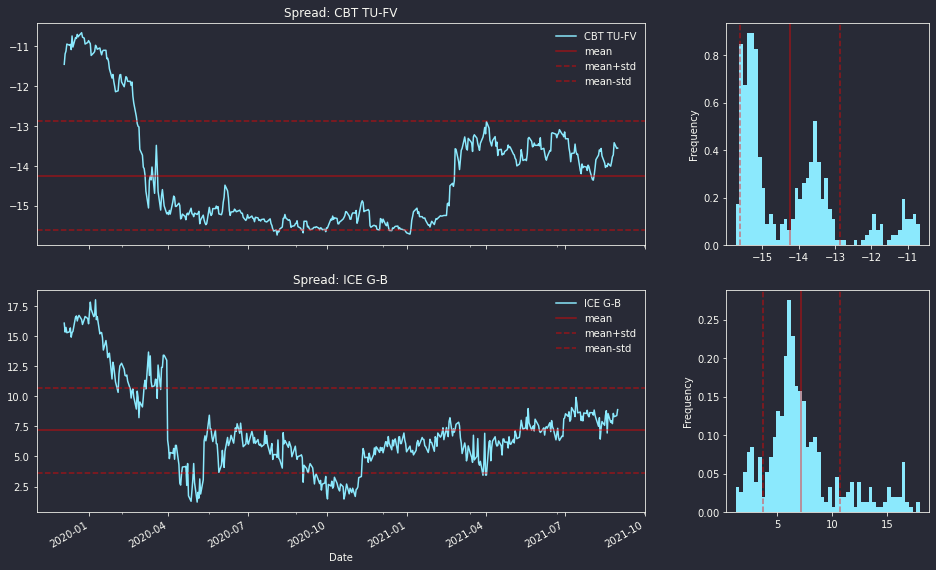

In [155]:
def plot_ts_hist(ts, ax):
    ts.plot(ax=ax[0])
    tsm = ts.mean()
    tss = ts.std()
    ax[0].axhline(tsm    , c='r', alpha=0.5, label="mean")
    ax[0].axhline(tsm+tss, c='r', alpha=0.5, linestyle="--", label="mean+std")
    ax[0].axhline(tsm-tss, c='r', alpha=0.5, linestyle="--", label="mean-std")
    ax[0].legend()
    ts.plot.hist(bins=50, ax=ax[1], density=True)
    ax[1].axvline(tsm    , c='r', alpha=0.5)
    ax[1].axvline(tsm+tss, c='r', alpha=0.5, linestyle="--")
    ax[1].axvline(tsm-tss, c='r', alpha=0.5, linestyle="--")

fig, axs = plt.subplots(2,2, gridspec_kw={"width_ratios":[3,1]})
axs[1,0].sharex(axs[0,0])

plot_ts_hist(spreads["CBT TU-FV"], axs[0])
axs[0,0].set_title(f"Spread: CBT TU-FV")
plot_ts_hist(spreads["ICE G-B"], axs[1])
axs[1,0].set_title(f"Spread: ICE G-B")

plt.show()

# 3.1 Data

Futures pairs W, X; Y, Z (in order) are as given by the last two distinct digits3 of your student number as follows:

The final number, where present, is a multiplier you should apply to X or Z before computing the spreads s.

When downloading from Quandl, you have to use the years and the quarterly codes (H, M, U, Z) individually, there is no facility for Quandl to combine them itself.

Examples of st on various dates that you should be matching in your own data are as follows:

My ID is 12129240 -> CBT_FV_FV (W), CBT_TU_TU (X), ICE_B_B (Y), ICE_G_G/7.45 (Z).